In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Загрузка изображения
image = cv2.imread('/content/tennis_court1.png')

WIDTH, HEIGHT = 1080, 720

image = cv2.resize(image, (WIDTH, HEIGHT))

Предобработка изображения

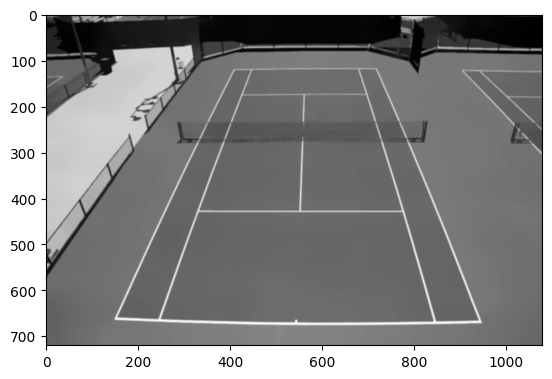

In [3]:
shifted = cv2.pyrMeanShiftFiltering(image, 21, 31)
# Преобразование изображения в градации серого
gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)
plt.imshow(gray, cmap='gray');

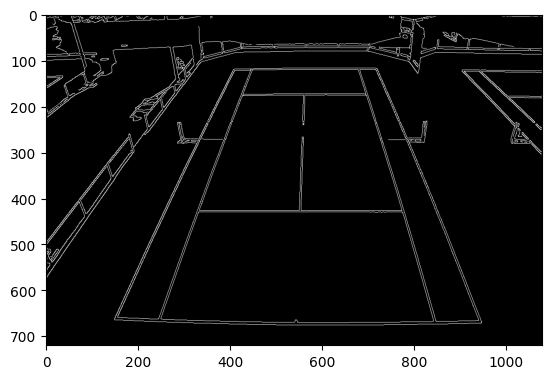

In [4]:
edged = cv2.Canny(gray, 30, 100)
plt.imshow(edged, cmap='gray');

Находим контуры на изображении.

In [5]:
contours, hierarchy = cv2.findContours(edged,
    cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

Отфильтруем контуры:
- т.к. корт находится в центре, можно избавиться от контуров сбоку
- уберем небольшие контуры

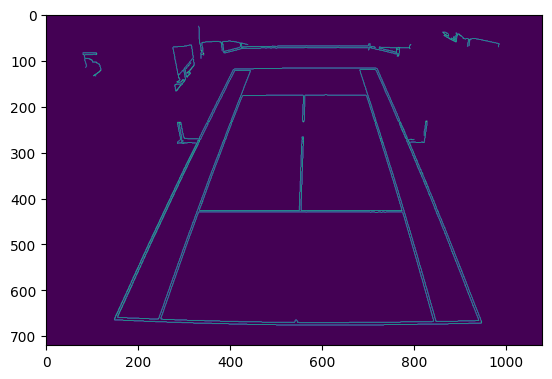

In [6]:
filtered_contours = []

delta = 20
for contour in contours:
    if len(contour) < 200:
      continue
    flag = True
    for point in contour:
      if point[0][0] < delta or point[0][0] > WIDTH - delta:
        flag = False
        break
      if point[0][1] < delta or point[0][1] > HEIGHT - delta:
        flag = False
        break
    if flag:
      filtered_contours.append(contour)

# Отрисовка контуров на черно-белом изображении
image_contours = np.zeros(image.shape[:2], dtype=np.uint8)
cv2.drawContours(image_contours, filtered_contours, -1, (255), 1)
plt.imshow(image_contours);

Найдем линии на этом изображении

In [7]:
def find_lines(image):
    lines = cv2.HoughLinesP(image, 1, np.pi / 180, 100, minLineLength=50, maxLineGap=10)
    return lines

In [8]:
lines = find_lines(image_contours)

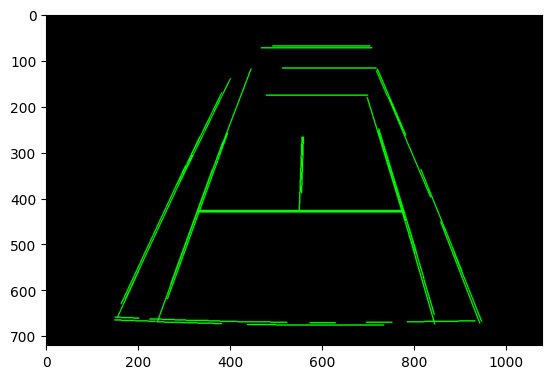

In [9]:
img_lines = np.zeros(image.shape, dtype=np.uint8)

for line in lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(img_lines, (x1, y1), (x2, y2), (0, 255, 0), 2)

plt.imshow(img_lines)

Классифицируем линии на горизонтальные и вертикальные

In [10]:
def classificate_line(lines):
    lines_classification = [[], []]
    for line in lines:
        line = line[0]
        dx = abs(line[0] - line[2])
        dy = abs(line[1] - line[3])
        if dx > dy:
            lines_classification[0].append(line)
        else:
            lines_classification[1].append(line)
    return lines_classification

In [11]:
lines_classification = classificate_line(lines)

Объеденим линии (Подробнее в дипломе)

In [12]:
def merging_lines(lines_classification):
    d = 15
    # Для горизонтальных линий
    for i in range(len(lines_classification[0])):
        if lines_classification[0][i][0] > lines_classification[0][i][2]:
            lines_classification[0][i] = (lines_classification[0][i][2], lines_classification[0][i][3],
                                          lines_classification[0][i][0], lines_classification[0][i][1])
    lines_classification[0].sort(key=lambda x: x[0])
    i = 0
    while i < len(lines_classification[0]):
        j = i + 1
        while j < len(lines_classification[0]):
            if abs(lines_classification[0][i][3] - lines_classification[0][j][1]) < d:
                if lines_classification[0][i][2] < lines_classification[0][j][2]:
                    lines_classification[0][i] = (lines_classification[0][i][0], (lines_classification[0][i][1] + lines_classification[0][j][1]) // 2,
                                                  lines_classification[0][j][2], (lines_classification[0][i][3] + lines_classification[0][j][3]) // 2)
                del lines_classification[0][j]
            else:
                j += 1
        i += 1

    # Для вертикальных линий
    for i in range(len(lines_classification[1])):
        if lines_classification[1][i][1] < lines_classification[1][i][3]:
            lines_classification[1][i] = (lines_classification[1][i][2], lines_classification[1][i][3],
                                          lines_classification[1][i][0], lines_classification[1][i][1])
    lines_classification[1].sort(key=lambda x: x[1], reverse=True)
    i = 0
    while i < len(lines_classification[1]):
        j = i + 1
        while j < len(lines_classification[1]):
            x1 = int(((HEIGHT / 2.0 - lines_classification[1][i][1]) / (lines_classification[1][i][3] - lines_classification[1][i][1])) *
                     (lines_classification[1][i][2] - lines_classification[1][i][0]) + lines_classification[1][i][0])
            x2 = int(((HEIGHT / 2.0 - lines_classification[1][j][1]) / (lines_classification[1][j][3] - lines_classification[1][j][1])) *
                     (lines_classification[1][j][2] - lines_classification[1][j][0]) + lines_classification[1][j][0])
            if abs(x1 - x2) < d:
                if lines_classification[1][i][3] > lines_classification[1][j][3]:
                    lines_classification[1][i] = (lines_classification[1][i][0], lines_classification[1][i][1],
                                                  lines_classification[1][j][2], lines_classification[1][j][3])
                del lines_classification[1][j]
            else:
                j += 1
        i += 1


In [13]:
print(len(lines_classification[0]), len(lines_classification[1]))
merging_lines(lines_classification)
print(len(lines_classification[0]), len(lines_classification[1]))

17 24
5 5


In [14]:
def draw_lines_classification(image, lines_classification):
    # Отрисовка горизонтальных линий красным цветом
    for line in lines_classification[0]:
        cv2.line(image, (line[0], line[1]), (line[2], line[3]), (0, 0, 255), 4)

    # Отрисовка вертикальных линий зеленым цветом
    for line in lines_classification[1]:
        cv2.line(image, (line[0], line[1]), (line[2], line[3]), (0, 255, 0), 4)

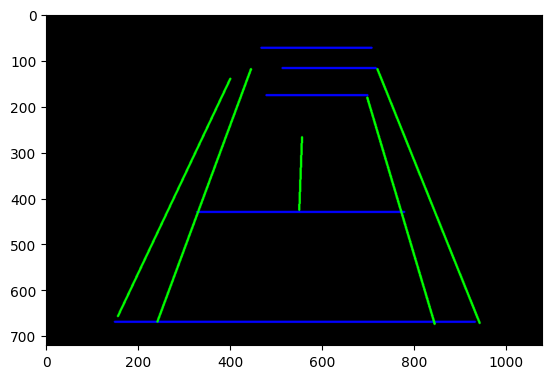

In [15]:
img_lines = np.zeros(image.shape, dtype=np.uint8)

draw_lines_classification(img_lines, lines_classification)

plt.imshow(img_lines)

In [16]:
import math

def angle_of_line(line):
    x1, y1, x2, y2 = line
    return math.atan2(x2 - x1, y2 - y1)

def line_intersection(line1, line2):
    x1, y1, x2, y2 = line1
    x3, y3, x4, y4 = line2
    denom = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
    if denom == 0:
        return None  # Линии параллельны или совпадают
    px = ((x1 * y2 - y1 * x2) * (x3 - x4) - (x1 - x2) * (x3 * y4 - y3 * x4)) / denom
    py = ((x1 * y2 - y1 * x2) * (y3 - y4) - (y1 - y2) * (x3 * y4 - y3 * x4)) / denom
    return int(px), int(py)

# Фигура корта схожа с трапецией
def compute_trapezoid_area(top_left, top_right, bottom_left, bottom_right):
    # Длины верхнего и нижнего оснований трапеции
    top_base_length = abs(top_right[0] - top_left[0])
    bottom_base_length = abs(bottom_right[0] - bottom_left[0])

    # Высота трапеции
    height = abs(top_left[1] - bottom_left[1])

    # Площадь трапеции
    area = ((top_base_length + bottom_base_length) * height) / 2

    return area

# Количество возможных пересечений, т.е. достают ли вертикальные линии до горизонтальных
def cntRealIntersections(h1, h2, v1, v2):
    cnt = 0
    delta = 15

    top_y = (h1[1] + h1[3]) // 2
    bottom_y = (h2[1] + h2[3]) // 2

    if abs(top_y - min(v1[1], v1[3])) < delta:
        cnt += 1
    if abs(top_y - min(v2[1], v2[3])) < delta:
        cnt += 1
    if abs(bottom_y - max(v1[1], v1[3])) < delta:
        cnt += 1
    if abs(bottom_y - max(v2[1], v2[3])) < delta:
        cnt += 1

    return cnt


Т.к. мы не можем использовать цвета, используем форму корта. На изображении это будет сравни равнобедренной трапеции. Т.е. есть 2 горизонтальные линии и 2 вертикальные с одинаковым наклоном. Найдем наибольшую подходящую фигуру (т.к. внутренние части корта тоже подходят под это)

In [17]:
import itertools

def find_tennis_court(lines_horizontal, lines_vertical):
    best_area = 0
    best_corners = None
    best_lines = None

    for h1, h2 in itertools.combinations(lines_horizontal, 2):
        for v1, v2 in itertools.combinations(lines_vertical, 2):
            # h1 - top, h2 - bottom
            if h1[1] > h2[1]:
                h1, h2 = h2, h1

            # v1 - left, v2 - right
            if v1[0] > v2[0]:
                v1, v2 = v2, v1

            # Вычисление углов наклона для вертикальных линий
            angle_h1 = angle_of_line(h1)
            angle_h2 = angle_of_line(h2)

            # Проверка на одинаковый угол наклона для горизонтальных линий с противоположными знаками и с учетом дельты
            if abs(angle_h1 - angle_h2) > 0.07:
                continue

            # Вычисление углов наклона для вертикальных линий
            angle_v1 = angle_of_line(v1)
            angle_v2 = angle_of_line(v2)
            # Проверка на одинаковый угол наклона для вертикальных линий с противоположными знаками и с учетом дельты
            if abs(angle_v1 + angle_v2) > 0.17:
                continue

            # Находим пересечения линий (возможные углы корта)
            top_left = line_intersection(h1, v1)
            top_right = line_intersection(h1, v2)
            bottom_left = line_intersection(h2, v1)
            bottom_right = line_intersection(h2, v2)

            intersections = [top_left, top_right, bottom_left, bottom_right]

            # Проверяем находятся ли углы на изображении
            flag = False
            for intersection in intersections:
                if intersection is None:
                  flag = True
                  break
                if intersection[0] > WIDTH or intersection[0] < 0:
                  flag = True
                  break
                if intersection[1] > HEIGHT or intersection[1] < 0:
                  flag = True
                  break

            if flag:
              continue

            # Как минимум три возможных пересечений у детектированных линий
            if cntRealIntersections(h1, h2, v1, v2) < 3:
              continue

            # Вычисление площади внутреннего прямоугольника (трапеции)
            area = compute_trapezoid_area(top_left, top_right, bottom_left, bottom_right)

            # Обновление наилучшей комбинации, если новая площадь больше
            if area > best_area:
                best_area = area
                best_corners = (top_left, top_right, bottom_left, bottom_right)
                best_lines = (h1, h2, v1, v2)

    return best_corners, best_lines


In [18]:
best_corners, best_lines = find_tennis_court(lines_classification[0], lines_classification[1])

In [19]:
print(best_corners)

((411, 117), (720, 117), (150, 669), (942, 669))


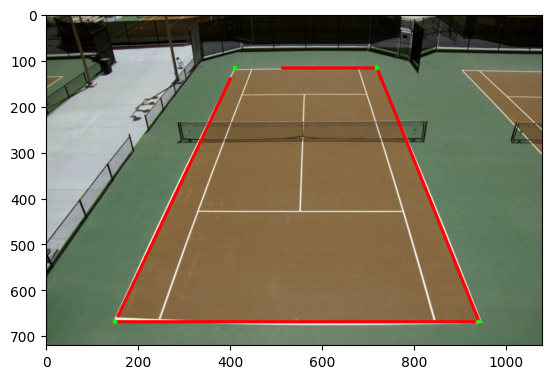

In [20]:
buf = np.copy(image)

# Отрисовка горизонтальных линий красным цветом
for line in best_lines:
    cv2.line(buf, (line[0], line[1]), (line[2], line[3]), (255, 0, 0), 5)

# Отрисовка вертикальных линий зеленым цветом
for corner in best_corners:
    cv2.circle(buf, (corner[0], corner[1]), 5, (0, 255, 0), -1)

plt.imshow(buf)